# Gini-to-Fourier Analysis

This is an example of the general process for analyzing a new dataset, both calculating and plotting the Gini Coefficients & Fourier Transforms.

In [1]:
# General Imports & Read in Data
import pandas as pd 
import numpy as np 

df = pd.read_csv("Data Quality (Stocks)/Stocks_Cleaned.csv") #Point this read-in to a cleaned dataset file 

# View Read-In df
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
658515,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
658516,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
658517,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
658518,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


For this example we will be analyzing Volume & its distribution amongst Ticker Symbols (Name). 

In this study we need __3 columns__ to conduct the base analysis;
- `Date/Time`- this must be an __UNINTERUPTED__ sequence of timestamps (in this case daily volume values for each Ticker)
- `Categorical`- Variable/Category (Ticker Symbols or Companies)
- `Distribution`- of some value for that Category (Respective trading Volume for each Ticker per day)

## Gini Calculation

- StackOverflow Example - https://stackoverflow.com/questions/48981516/weighted-gini-coefficient-in-python 
- Wikipedia Article - https://en.wikipedia.org/wiki/Gini_coefficient (read the calculation section in depth, the approach below is a mathematically equivalent way of calculating Gini coefficents, a different approach than what is typically used by Economists)

In [2]:
# User-Defined Gini Function

def gini(x, weights=None): 
    if weights is None: #can weight specific inputs, non-essential if we just pass in the weights themselves (volume in this case)
        weights = np.ones_like(x)
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum() #mean absolute deviation
    rmad = mad / np.average(x, weights=weights) #relative mean absolute deviation 
    return 0.5 * rmad #half the RMAD is mathematically equivalent to the typical economics Gini calculation

In [3]:
# Calculate Gini Values per Date (Categorical isn't needed after Gini Calculation, aggregates the inequality in distribution)

# Vars 
volume_dict = {'DATE':[], "GINI":[]}

for date in df["date"].unique():
    df_date = df[df["date"]==date]
    volume_dict["DATE"].append(date)
    
    # Get Distribution of Volumes for Current Date
    daily_distribution = [val for val in df_date["volume"]]
    #volume_dict["TOTAL"].append(daily_distribution)
    
    # Save Prior Day Value (in-case NaN, will fill prior day val)
    try: 
        gc_1 = gc 
    except: 
        pass

    # Apply User Defined Gini Function to Data
    gc = gini(daily_distribution)
    
    
    # NaNs in this case seem to be holidays (checked about 10 dates manually, all were weekends or holidays) -- this can very from dataset to dataset, need to investigate in EDA
    if np.isnan(gc):
        #gc = 0 # no trading volume for date -- not exactly "missing", will impute previous day as value
        gc = gc_1 #for nans impute previous days 

    volume_dict["GINI"].append(gc)


/Users/ckg-files/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


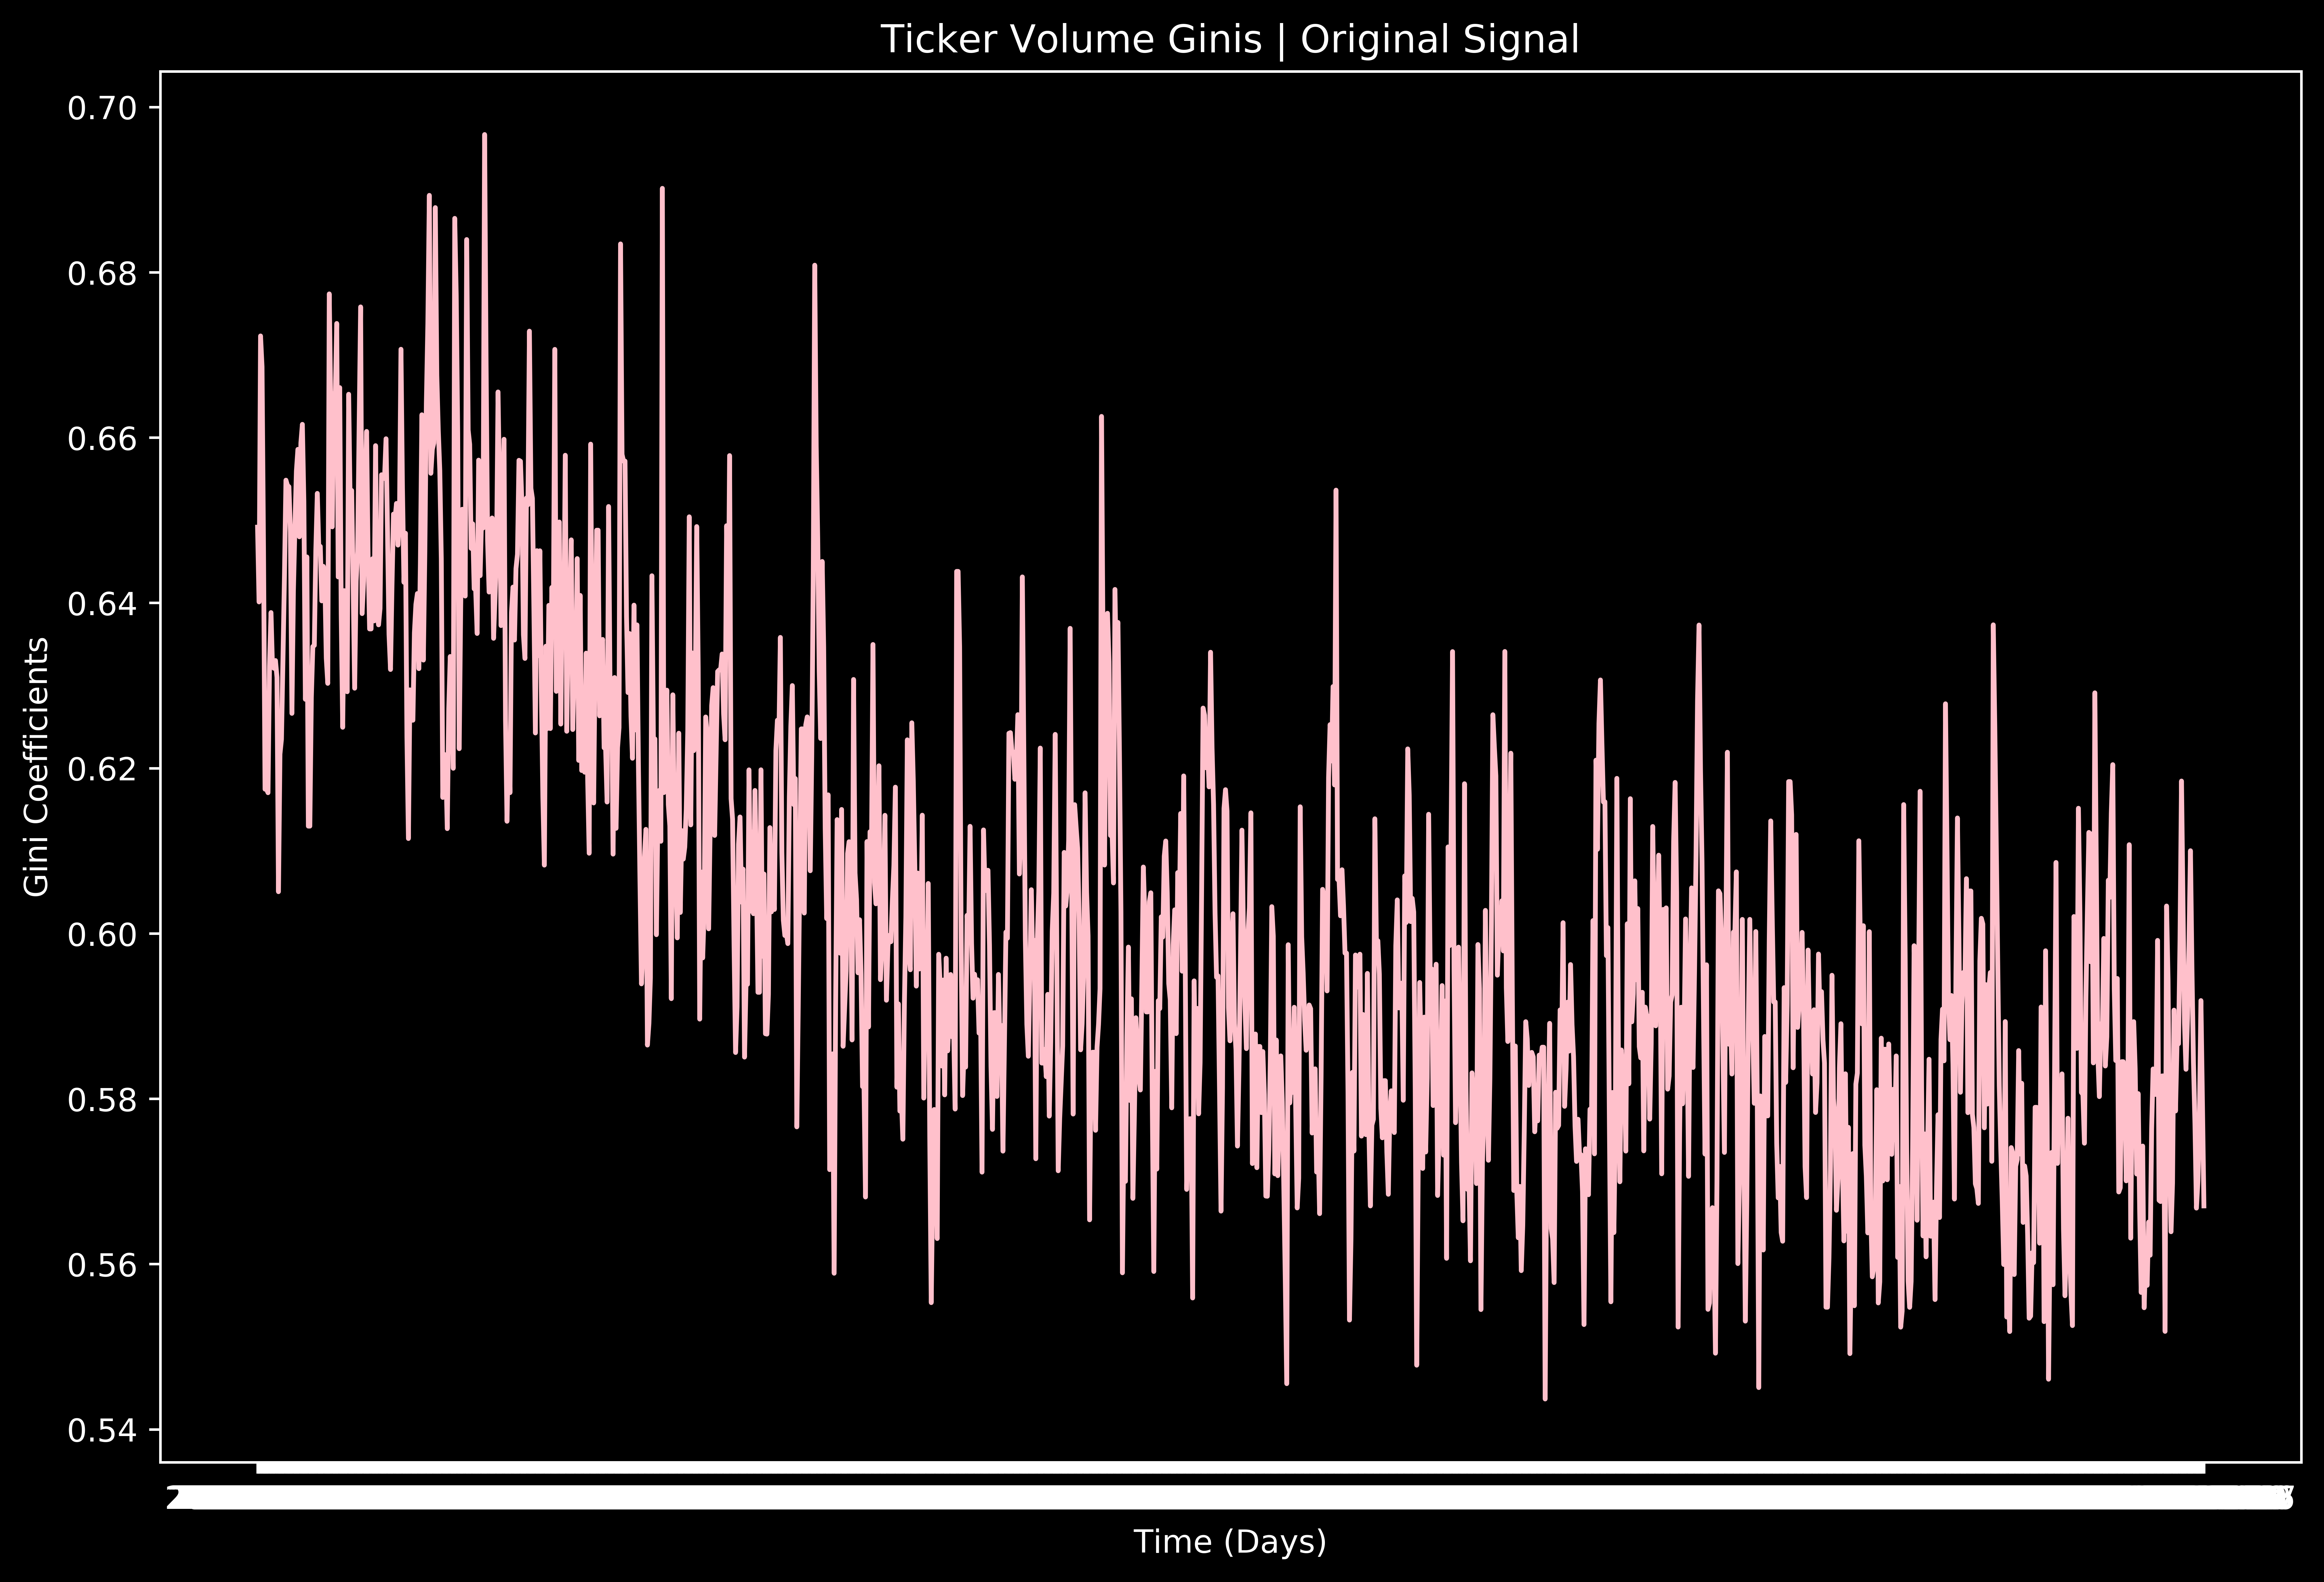

In [5]:
# Plot Gini Coefficients Over Time Horizon
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")


# Get Data for Plotting
dft = pd.DataFrame.from_dict(volume_dict)
dft = dft.sort_values(by=['DATE'])

dates = dft["DATE"]
gini_values = dft["GINI"]


# Generate Plot
plt.figure(figsize=(12, 8), dpi=800)
ax = plt.axes()
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Gini Coefficients")
ax.set_title("Ticker Volume Ginis | Original Signal")
ax.plot(dates, gini_values, color="Pink")

## Fourier Transform

- 3Blue1Brown [Explanation Video](https://www.youtube.com/watch?v=spUNpyF58BY&ab_channel=3Blue1Brown)- brilliant introduction for building an intuition about what the Fourier does, highly recommend watching prior to below

/Users/ckg-files/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


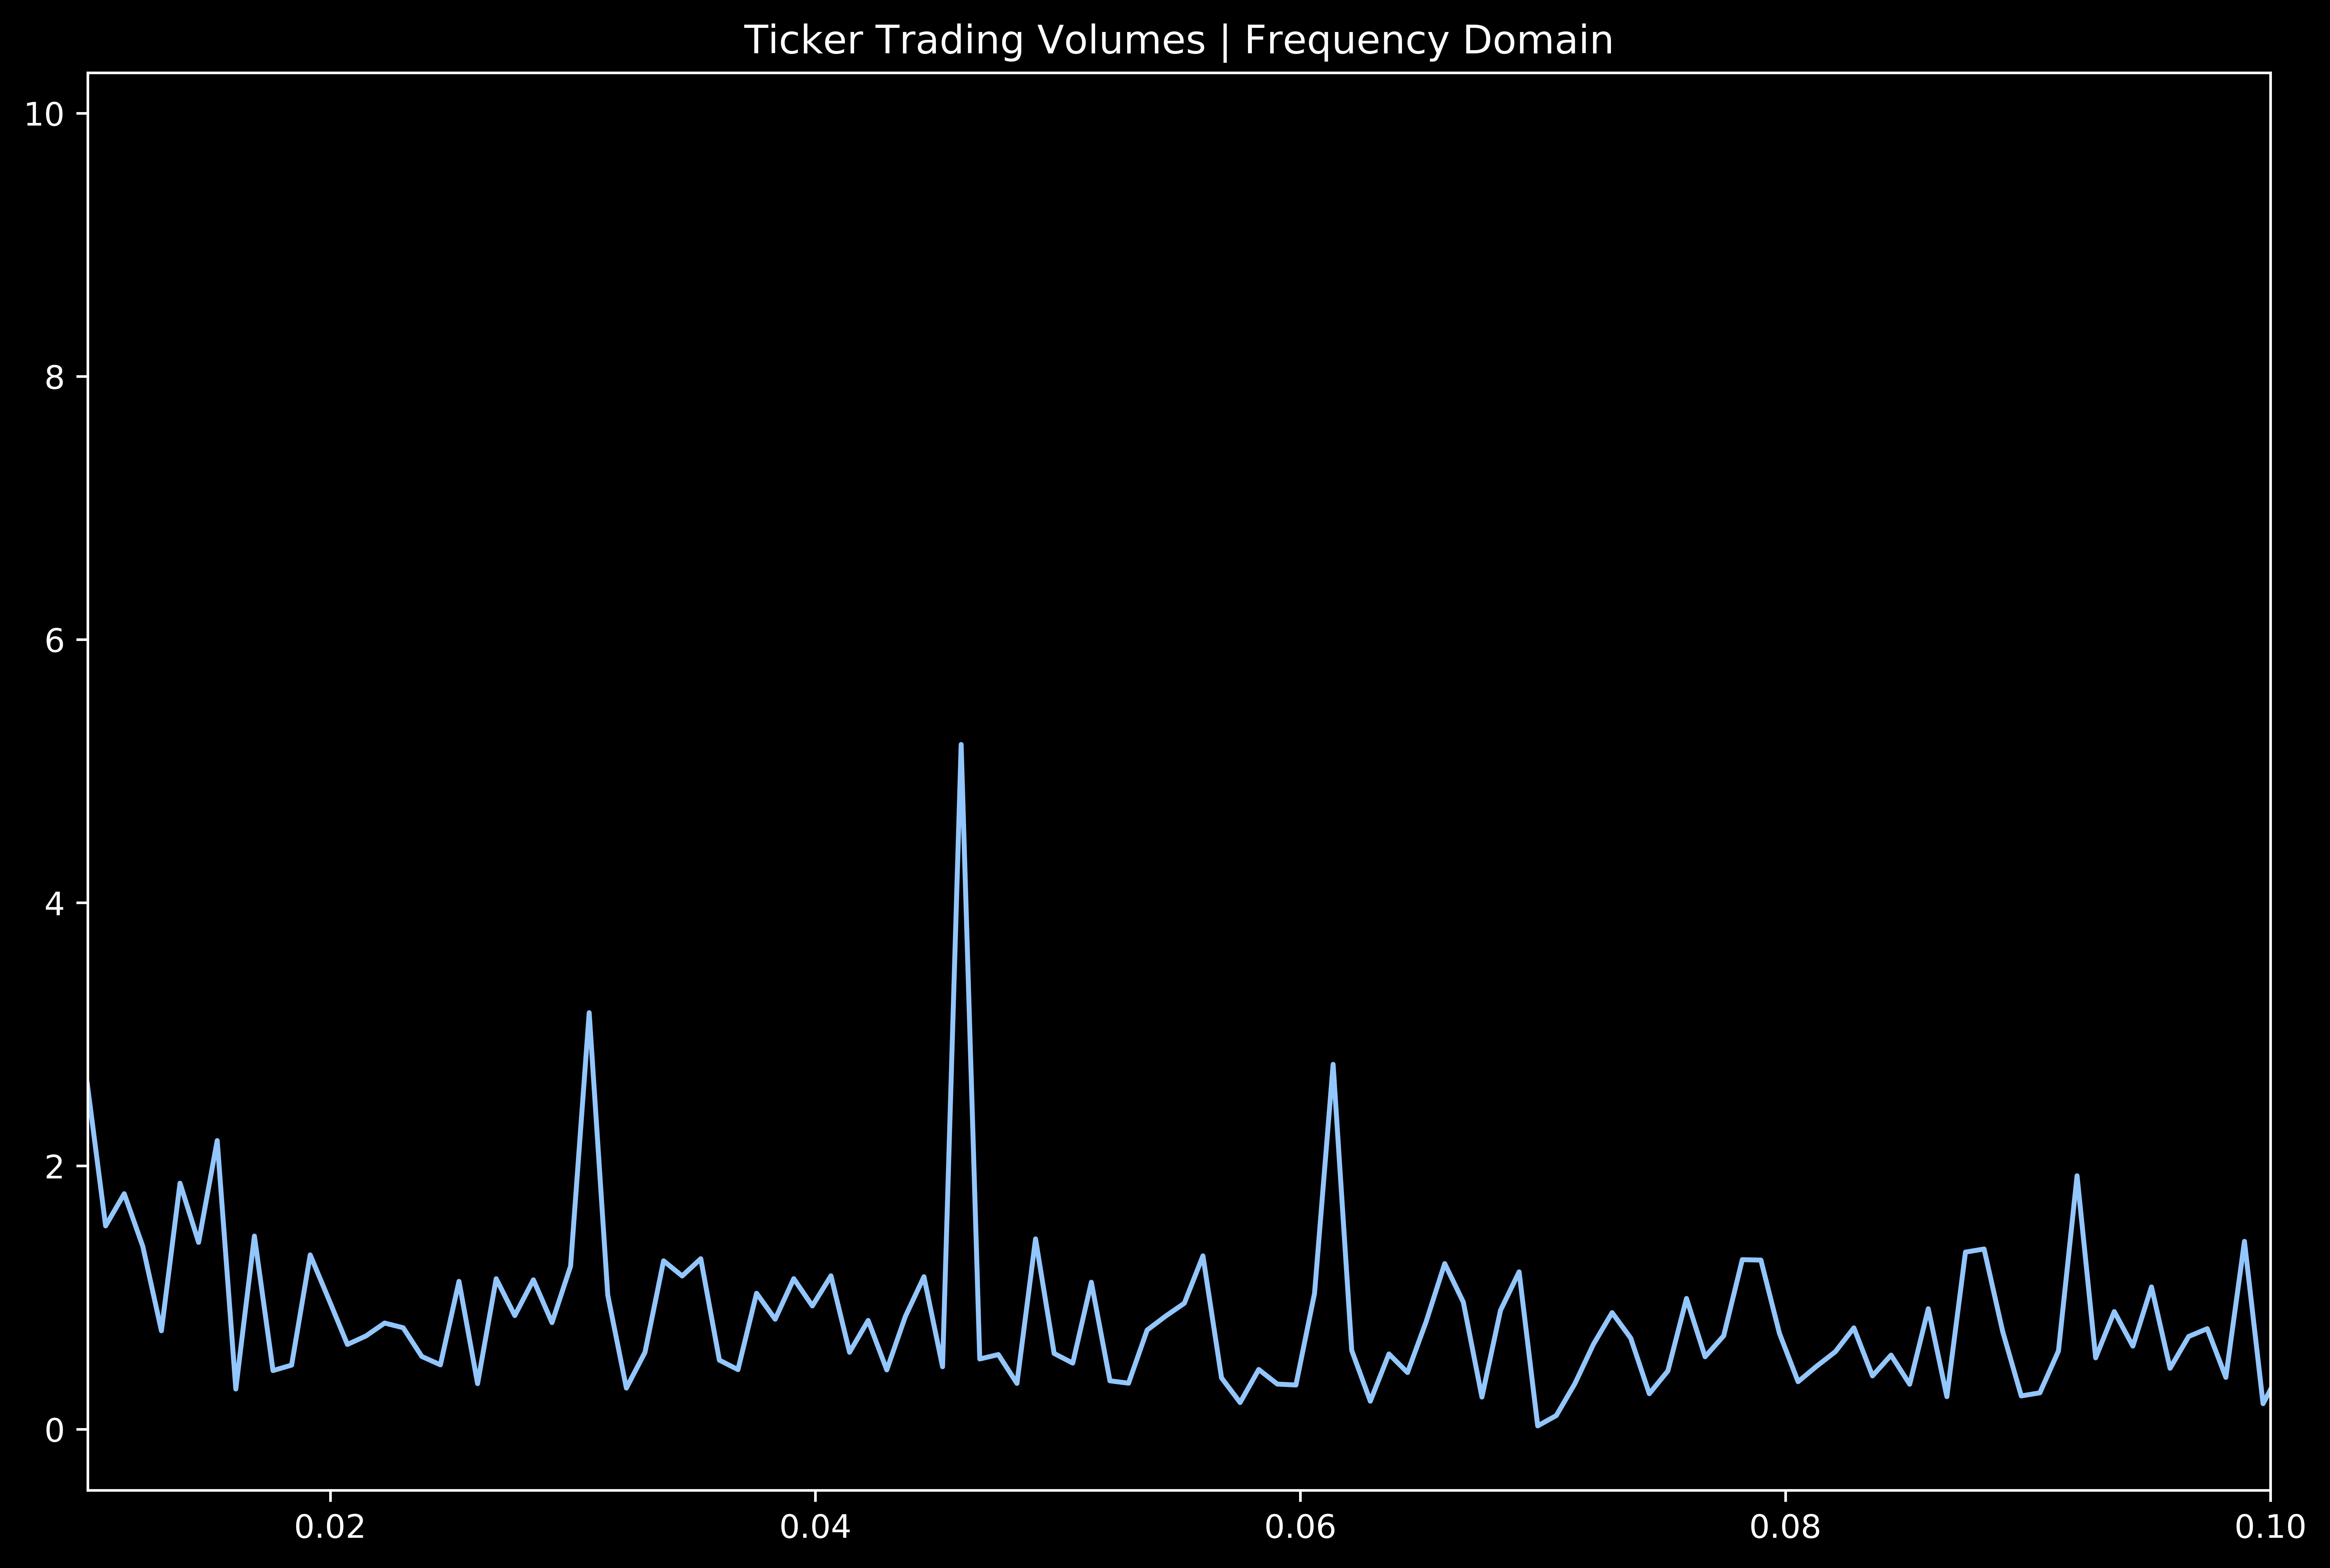

In [24]:
# Make Arrays of Gini Coefficents
input_array = dft["GINI"].to_numpy()


# RFFT Application – Specific Fourier Transform Chosen, already filters out negative portion
from scipy.fft import rfft, rfftfreq

# Number of samples in `normalized_tone`
N = len(input_array)

x = rfftfreq(N, d=1) #1 gini value per day 
y = rfft(input_array) #calculate the Fourier Value on input array

# Filter out the Noise (Signals very close to zero are likely to be noise, use the mask below to test different thresholds & the resulting graph)
mask = (x >= 0.001) #change Float value to set cutoff threshold
x = x[mask]
y = y[mask]


# Plot Fourier Tranform - Data in Frequency Domain
plt.figure(figsize=(12, 8), dpi=800)
plt.plot(x, np.abs(y))
plt.xlim(0.01, 0.1) #limit axis range - useful if trying to zoom in on a specific part of graph (did so with stocks data to investigate longer temporal window signals)
plt.axes().set_title("Ticker Trading Volumes | Frequency Domain")
plt.show()